# Baseline Model: Logistic Regression 

We train two simple models on our training data and validate it on our validation data. The two models are:

- logistic regression on the data after removing all observations with NAs
- logistic regression on the data after filling in all NA values with the mean. 

The default L2 regularization is used. This is meant to give us a baseline from which we will show improvements with iterative models. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

## Read in the Data

In [27]:
df, train, test = load_data.load_coral_data(complete=False, CV=True, convert_to_categorical=True)

#### Confirm that there are NAs

In [28]:
# look at how many NAs exist in the data set
df_nas = df.apply(lambda x : x.isna().sum())

# verify that there are no NAs in the data set anymore
df_nas[df_nas > 0]

Complexity    113
Depth          12
dtype: int64

In [29]:
train_nas = train.apply(lambda x : x.isna().sum())
print("Train NAs: \n", train_nas[train_nas > 0])
print("")

Train NAs: 
 Complexity    107
Depth           3
dtype: int64



### Data Prep

##### Drop all rows with NAs

In [8]:
train_X_noNAs = train.dropna()
train_X_noNAs, train_y_noNAs, pred_names  = load_data.get_features_and_response(train_X_noNAs, with_feature_eng = False)

##### Fill in NAs with mean

In [11]:
# isolate the predictors and labels for both the training and test set
train_X, train_y, pred_names  = load_data.get_features_and_response(train, with_feature_eng = False)

In [12]:
train_X["Complexity"] = train_X["Complexity"].transform(lambda x: x.fillna(x.mean()))
train_X["Depth"] = train_X["Depth"].transform(lambda x: x.fillna(x.mean()))

### Standardize the data

In [13]:
scaler = StandardScaler()
scaler_noNas = StandardScaler()

# Fit on training set only.
scaler_noNas.fit(train_X_noNAs.values)

# Apply transform to both the training set and the test set.
train_X_noNAs = scaler_noNas.transform(train_X_noNAs.values)

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)

### Multinomial logistic regression model on data without NAs

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
hyperparameters = dict()
clf = GridSearchCV(LogisticRegression(solver='newton-cg',
                                      multi_class='multinomial', 
                                      penalty='l2',
                                      random_state=1), 
                   hyperparameters, cv=5, verbose=0, iid=False,
                   scoring=make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                   return_train_score=True)
best_model = clf.fit(train_X_noNAs, train_y_noNAs)

# Best Model is the model picked with the optimal C retrained on the
# entire training data
# clf_multi = LogisticRegression(solver='newton-cg', multi_class='multinomial')
# clf_multi.fit(train_X_noNAs, train_y_noNAs)

In [22]:
best_model.cv_results_

{'mean_fit_time': array([0.02017541]),
 'std_fit_time': array([0.00527594]),
 'mean_score_time': array([0.00158138]),
 'std_score_time': array([0.00061836]),
 'params': [{}],
 'split0_test_score': array([0.6875]),
 'split1_test_score': array([0.66666667]),
 'split2_test_score': array([0.63636364]),
 'split3_test_score': array([0.67105263]),
 'split4_test_score': array([0.63157895]),
 'mean_test_score': array([0.65863238]),
 'std_test_score': array([0.02135386]),
 'rank_test_score': array([1], dtype=int32),
 'split0_train_score': array([0.71009772]),
 'split1_train_score': array([0.72491909]),
 'split2_train_score': array([0.7]),
 'split3_train_score': array([0.71382637]),
 'split4_train_score': array([0.72347267]),
 'mean_train_score': array([0.71446317]),
 'std_train_score': array([0.0091558])}

##### Make predictions

In [ ]:
val_pred_multi = clf_multi.predict(val_X_noNAs)

##### Evaluate performance

Misclassified samples: 31
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.67      0.64        24
           2       0.79      0.71      0.75        21
           3       0.54      0.70      0.61        20
           5       0.62      0.42      0.50        19

    accuracy                           0.63        84
   macro avg       0.64      0.63      0.62        84
weighted avg       0.64      0.63      0.63        84



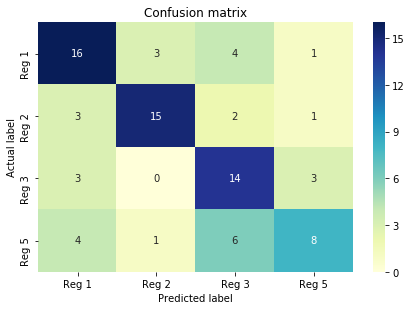

In [47]:
evaluate_performance(val_y_noNAs, val_pred_multi)

### Multinomial logistic regression model on data with NAs filled in as mean

In [25]:
hyperparameters = dict()
clf = GridSearchCV(LogisticRegression(solver='newton-cg',
                                      multi_class='multinomial', 
                                      penalty='l2',
                                      random_state=1), 
                   hyperparameters, cv=5, verbose=0, iid=False,
                   scoring=make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                   return_train_score=True)
best_model = clf.fit(train_X, train_y)
best_model.cv_results_

{'mean_fit_time': array([0.01931381]),
 'std_fit_time': array([0.00441025]),
 'mean_score_time': array([0.00114083]),
 'std_score_time': array([0.00013312]),
 'params': [{}],
 'split0_test_score': array([0.65346535]),
 'split1_test_score': array([0.55]),
 'split2_test_score': array([0.62626263]),
 'split3_test_score': array([0.55555556]),
 'split4_test_score': array([0.62886598]),
 'mean_test_score': array([0.6028299]),
 'std_test_score': array([0.04199233]),
 'rank_test_score': array([1], dtype=int32),
 'split0_train_score': array([0.66075949]),
 'split1_train_score': array([0.69444444]),
 'split2_train_score': array([0.70277078]),
 'split3_train_score': array([0.67254408]),
 'split4_train_score': array([0.65413534]),
 'mean_train_score': array([0.67693083]),
 'std_train_score': array([0.01884049])}

##### Make predictions

In [50]:
val_pred_multi = clf_multi.predict(val_X)

##### Evaluate performance

Misclassified samples: 35
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.58      0.60        26
           2       0.76      0.79      0.77        28
           3       0.59      0.76      0.67        25
           5       0.60      0.43      0.50        21

    accuracy                           0.65       100
   macro avg       0.64      0.64      0.63       100
weighted avg       0.65      0.65      0.64       100



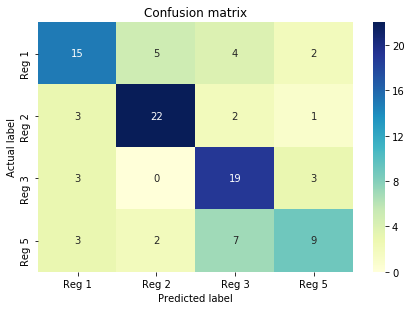

In [51]:
evaluate_performance(val_y, val_pred_multi)

## Findings:

Filling in the missing values for Complexity helped out with the F1 score - it increased the micro F1-score from 0.63 to 0.65. This slight increase may be due to just using more observations. However, we should fill in these missing values.